# Simple $e^+e^- \to \mu^+ \mu^- $ Monte Carlo Event Generator example

Differential cross section:
$$
\frac{d \sigma}{ d \Omega} = \frac{\alpha^2}{4 s } ( 1+ \cos^2(\theta))
$$

In [1]:
import math
import random

import hist
import numpy as np

import pylhe

In [2]:
alpha = 1 / 127.4  # alpha QED
aqcd = 0.1075  # alpha QCD
EB = 209
s = (2 * EB) ** 2
theta_min = 0
theta_max = math.pi
phi_min = 0
phi_max = 2 * math.pi

In [3]:
# https://equation-database.readthedocs.io/en/latest/_autosummary/equation_database.isbn_9780471887416.html#equation_database.isbn_9780471887416.equation_6_32


def dsigma(s, theta, _phi):
    return (math.cos(theta) ** 2 + 1) / 4 * alpha**2 / s

In [4]:
# Monte Carlo integration


def monte_carlo_integration(
    func, s, theta_min, theta_max, phi_min, phi_max, num_samples
):
    theta_samples = [random.uniform(theta_min, theta_max) for _ in range(num_samples)]
    phi_samples = [random.uniform(phi_min, phi_max) for _ in range(num_samples)]
    func_values = [
        (phi_max - phi_min)
        * (theta_max - theta_min)
        * func(s, theta, phi)
        * math.sin(theta)
        for theta, phi in zip(theta_samples, phi_samples)
    ]
    maximum = np.max(func_values)
    integral = np.mean(func_values)
    return integral, maximum


# Parameters

num_samples = 1_000_000

# Perform integration
result, maximum = monte_carlo_integration(
    dsigma, s, theta_min, theta_max, phi_min, phi_max, num_samples
)
print(f"Estimated integral: {result}")

# https://equation-database.readthedocs.io/en/latest/_autosummary/equation_database.isbn_9780471887416.html#equation_database.isbn_9780471887416.equation_6_33
sigma = 4 * math.pi / 3 * alpha**2 / s
print(f"Real integral:      {sigma}")

Estimated integral: 1.4768119622917573e-09
Real integral:      1.477056777521761e-09


## Weighted Events

The information about the distribution is carried by the weights of the events.

In [5]:
num_samples = 1_000_000
integ = 0.0
lheevents = []
for _i in range(num_samples):
    theta = random.uniform(theta_min, theta_max)
    phi = random.uniform(phi_min, phi_max)
    sig = (
        (phi_max - phi_min)
        * (theta_max - theta_min)
        * dsigma(s, theta, phi)
        * math.sin(theta)
        / num_samples
    )
    integ += sig
    # Fill the LHE event
    e = pylhe.LHEEvent(
        eventinfo=pylhe.LHEEventInfo(
            nparticles=5,
            pid=0,
            weight=sig,  # The individual weight per event
            scale=s,
            aqed=alpha,
            aqcd=aqcd,
        ),
        particles=[
            pylhe.LHEParticle(
                id=11,
                status=-1,
                mother1=0,
                mother2=0,
                color1=0,
                color2=0,
                px=0.0,
                py=0.0,
                pz=EB,
                e=EB,
                m=0.0,
                lifetime=0,
                spin=9.0,
            ),
            pylhe.LHEParticle(
                id=-11,
                status=-1,
                mother1=0,
                mother2=0,
                color1=0,
                color2=0,
                px=0.0,
                py=0.0,
                pz=-EB,
                e=EB,
                m=0.0,
                lifetime=0,
                spin=9.0,
            ),
            pylhe.LHEParticle(
                id=22,
                status=2,
                mother1=1,
                mother2=2,
                color1=0,
                color2=0,
                px=0.0,
                py=0.0,
                pz=EB - EB,
                e=EB + EB,
                m=0.0,
                lifetime=0,
                spin=9.0,
            ),
            pylhe.LHEParticle(
                id=13,
                status=1,
                mother1=3,
                mother2=3,
                color1=0,
                color2=0,
                px=EB * math.sin(theta) * math.cos(phi),
                py=EB * math.sin(theta) * math.sin(phi),
                pz=EB * math.cos(theta),
                e=EB,
                m=0,
                lifetime=0,
                spin=9.0,
            ),
            pylhe.LHEParticle(
                id=-13,
                status=1,
                mother1=3,
                mother2=3,
                color1=0,
                color2=0,
                px=-EB * math.sin(theta) * math.cos(phi),
                py=-EB * math.sin(theta) * math.sin(phi),
                pz=-EB * math.cos(theta),
                e=EB,
                m=0,
                lifetime=0,
                spin=9.0,
            ),
        ],
    )
    lheevents.append(e)
# Fill the LHE init
lheinit = pylhe.LHEInit(
    initInfo=pylhe.LHEInitInfo(
        beamA=11,
        beamB=-11,
        energyA=EB,
        energyB=EB,
        PDFgroupA=0,
        PDFgroupB=0,
        PDFsetA=0,
        PDFsetB=0,
        weightingStrategy=3,
        numProcesses=1,
    ),
    procInfo=[
        pylhe.LHEProcInfo(
            xSection=integ,
            error=0,
            unitWeight=1,
            procId=1,
        )
    ],
    weightgroup={},
    LHEVersion=3,
)
print(pylhe.write_lhe_string(lheinit, lheevents[0:3], rwgt=False, weights=False))
pylhe.write_lhe_file(
    lheinit, lheevents, filepath="weighted.lhe.gz", rwgt=False, weights=False
)

<LesHouchesEvents version="3">
<init>
     11    -11  2.0900000e+02  2.0900000e+02     0     0     0     0     3     1
 1.4762645e-09  0.0000000e+00  1.0000000e+00     1
<initrwgt /></init>
<event>
  5      0  9.2457885677e-16  1.7472400000e+05  7.8492935636e-03  1.0750000000e-01
   11  -1   0   0   0   0  0.00000000e+00  0.00000000e+00  2.09000000e+02  2.09000000e+02  0.00000000e+00  0.0000e+00  9.0000e+00
  -11  -1   0   0   0   0  0.00000000e+00  0.00000000e+00 -2.09000000e+02  2.09000000e+02  0.00000000e+00  0.0000e+00  9.0000e+00
   22   2   1   2   0   0  0.00000000e+00  0.00000000e+00  0.00000000e+00  4.18000000e+02  0.00000000e+00  0.0000e+00  9.0000e+00
   13   1   3   3   0   0  4.67080899e+01 -3.39212045e+01  2.00869874e+02  2.09000000e+02  0.00000000e+00  0.0000e+00  9.0000e+00
  -13   1   3   3   0   0 -4.67080899e+01  3.39212045e+01 -2.00869874e+02  2.09000000e+02  0.00000000e+00  0.0000e+00  9.0000e+00
</event>
<event>
  5      0  1.7027957887e-15  1.7472400000e+05  7.84

In [6]:
arr = pylhe.to_awkward(pylhe.read_lhe_with_attributes("weighted.lhe.gz"))
hist1 = hist.Hist.new.Reg(20, 0, math.pi).Weight()
hist1.fill(arr.particles.vector[:, -1].theta, weight=arr.eventinfo.weight)

Hist(Regular(20, 0, 3.14159, label='Axis 0'), storage=Weight()) # Sum: WeightedSum(value=1.47626e-09, variance=2.45864e-24)

[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7ff693cd41a0>, errorbar=<ErrorbarContainer object of 3 artists>, legend_artist=<ErrorbarContainer object of 3 artists>)]

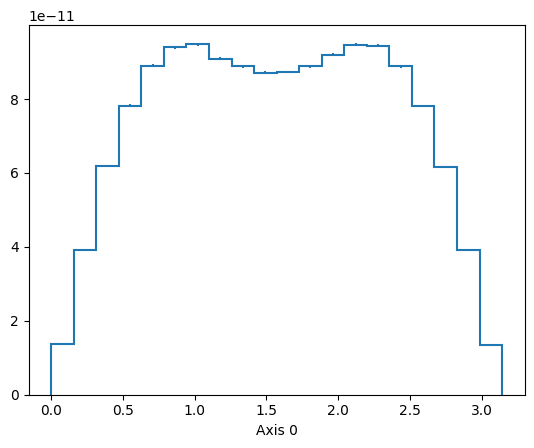

In [7]:
hist1.plot()

## Unweighted Events

The information about the distribution is carried by the distribution/number of the events.

In [8]:
num_samples = 1_000_000
integ = 0.0
lheevents = []
while len(lheevents) < num_samples:
    theta = random.uniform(theta_min, theta_max)
    phi = random.uniform(phi_min, phi_max)
    sig = (
        (phi_max - phi_min)
        * (theta_max - theta_min)
        * dsigma(s, theta, phi)
        * math.sin(theta)
    )
    if sig / maximum > random.uniform(
        0, 1
    ):  # Pick events randomly according to their contribution
        e = pylhe.LHEEvent(
            eventinfo=pylhe.LHEEventInfo(
                nparticles=5,
                pid=0,
                weight=result / num_samples,  # The same weight per event
                scale=s,
                aqed=alpha,
                aqcd=aqcd,
            ),
            particles=[
                pylhe.LHEParticle(
                    id=11,
                    status=-1,
                    mother1=0,
                    mother2=0,
                    color1=0,
                    color2=0,
                    px=0.0,
                    py=0.0,
                    pz=EB,
                    e=EB,
                    m=0.0,
                    lifetime=0,
                    spin=9.0,
                ),
                pylhe.LHEParticle(
                    id=-11,
                    status=-1,
                    mother1=0,
                    mother2=0,
                    color1=0,
                    color2=0,
                    px=0.0,
                    py=0.0,
                    pz=-EB,
                    e=EB,
                    m=0.0,
                    lifetime=0,
                    spin=9.0,
                ),
                pylhe.LHEParticle(
                    id=22,
                    status=2,
                    mother1=1,
                    mother2=2,
                    color1=0,
                    color2=0,
                    px=0.0,
                    py=0.0,
                    pz=EB - EB,
                    e=EB + EB,
                    m=0.0,
                    lifetime=0,
                    spin=9.0,
                ),
                pylhe.LHEParticle(
                    id=13,
                    status=1,
                    mother1=3,
                    mother2=3,
                    color1=0,
                    color2=0,
                    px=EB * math.sin(theta) * math.cos(phi),
                    py=EB * math.sin(theta) * math.sin(phi),
                    pz=EB * math.cos(theta),
                    e=EB,
                    m=0,
                    lifetime=0,
                    spin=9.0,
                ),
                pylhe.LHEParticle(
                    id=-13,
                    status=1,
                    mother1=3,
                    mother2=3,
                    color1=0,
                    color2=0,
                    px=-EB * math.sin(theta) * math.cos(phi),
                    py=-EB * math.sin(theta) * math.sin(phi),
                    pz=-EB * math.cos(theta),
                    e=EB,
                    m=0,
                    lifetime=0,
                    spin=9.0,
                ),
            ],
        )
        lheevents.append(e)
lheinit = pylhe.LHEInit(
    initInfo=pylhe.LHEInitInfo(
        beamA=11,
        beamB=-11,
        energyA=EB,
        energyB=EB,
        PDFgroupA=0,
        PDFgroupB=0,
        PDFsetA=0,
        PDFsetB=0,
        weightingStrategy=3,
        numProcesses=1,
    ),
    procInfo=[
        pylhe.LHEProcInfo(
            xSection=result,
            error=0,
            unitWeight=1,
            procId=1,
        )
    ],
    weightgroup={},
    LHEVersion=3,
)
print(pylhe.write_lhe_string(lheinit, lheevents[0:3], rwgt=False, weights=False))
pylhe.write_lhe_file(
    lheinit, lheevents, filepath="unweighted.lhe", rwgt=False, weights=False
)

<LesHouchesEvents version="3">
<init>
     11    -11  2.0900000e+02  2.0900000e+02     0     0     0     0     3     1
 1.4768120e-09  0.0000000e+00  1.0000000e+00     1
<initrwgt /></init>
<event>
  5      0  1.4768119623e-15  1.7472400000e+05  7.8492935636e-03  1.0750000000e-01
   11  -1   0   0   0   0  0.00000000e+00  0.00000000e+00  2.09000000e+02  2.09000000e+02  0.00000000e+00  0.0000e+00  9.0000e+00
  -11  -1   0   0   0   0  0.00000000e+00  0.00000000e+00 -2.09000000e+02  2.09000000e+02  0.00000000e+00  0.0000e+00  9.0000e+00
   22   2   1   2   0   0  0.00000000e+00  0.00000000e+00  0.00000000e+00  4.18000000e+02  0.00000000e+00  0.0000e+00  9.0000e+00
   13   1   3   3   0   0 -9.44407459e+01  9.93544418e+01 -1.57767679e+02  2.09000000e+02  0.00000000e+00  0.0000e+00  9.0000e+00
  -13   1   3   3   0   0  9.44407459e+01 -9.93544418e+01  1.57767679e+02  2.09000000e+02  0.00000000e+00  0.0000e+00  9.0000e+00
</event>
<event>
  5      0  1.4768119623e-15  1.7472400000e+05  7.84

In [9]:
arr = pylhe.to_awkward(pylhe.read_lhe_with_attributes("unweighted.lhe"))
hist2 = hist.Hist.new.Reg(20, 0, math.pi).Weight()
hist2.fill(arr.particles.vector[:, -1].theta, weight=arr.eventinfo.weight)

Hist(Regular(20, 0, 3.14159, label='Axis 0'), storage=Weight()) # Sum: WeightedSum(value=1.47681e-09, variance=2.18097e-24)

[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7ff6ac71fc50>, errorbar=<ErrorbarContainer object of 3 artists>, legend_artist=<ErrorbarContainer object of 3 artists>)]

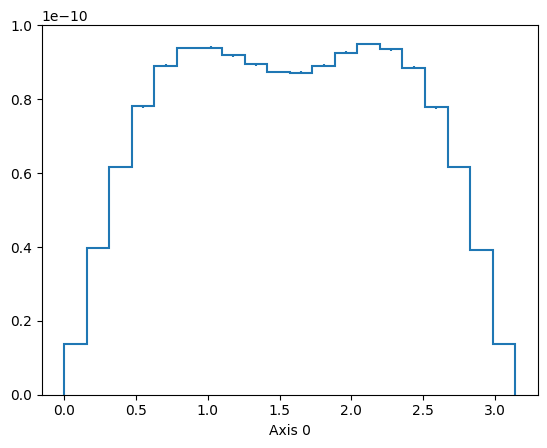

In [10]:
hist2.plot()

(([StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7ff6ac6f8910>, errorbar=<ErrorbarContainer object of 3 artists>, legend_artist=<ErrorbarContainer object of 3 artists>)],
  [StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7ff6ac6f87d0>, errorbar=<ErrorbarContainer object of 3 artists>, legend_artist=<ErrorbarContainer object of 3 artists>)]),
 RatioErrorbarArtists(line=<matplotlib.lines.Line2D object at 0x7ff6ac6f9450>, errorbar=<ErrorbarContainer object of 3 artists>))

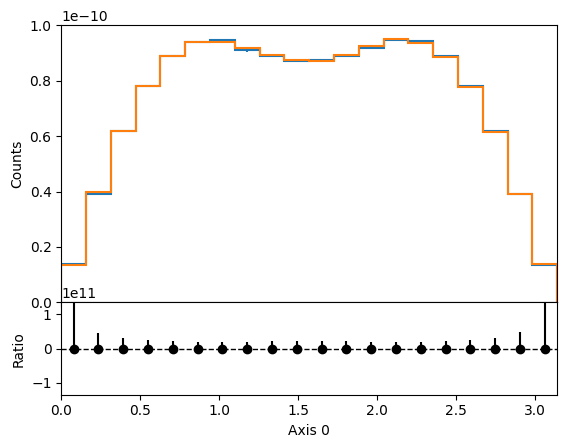

In [11]:
hist1.plot_ratio(hist2)